In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from zipfile import ZipFile
import os
from pathlib import Path
import sys
import glob
from os.path import join
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio 
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.mask
from pyproj import CRS
import matplotlib.pyplot as plt

# Move .zip Directories to Interim

In [15]:
# It could make sense to have a lib/ style directory
# like PLACES has for common functionality
# and this code block would be useful there for getting
# a fr() path

# Get the absolute path to the precal_hazard directory
# Which is two directories above notebooks/exploration/
abs_dir = os.path.abspath(Path(os.getcwd()).parents[1])
# Get raw data directory
fr = join(abs_dir, 'data', 'raw')
# Get interim data directory
fi = join(abs_dir, 'data', 'interim')
# Get processed data directory
fp = join(abs_dir, 'data', 'processed')

In [6]:
# For each .zip directory in fr
# Create needed subdirectories in interim/
# Unzip in the appropriate interim/ subdirectory

for path in Path(fr).rglob('*.zip'):
    # Avoid hidden files and files in directories
    if path.name[0] != '.':
        # Get root for the directory this .zip file is in
        zip_root = path.relative_to(fr).parents[0]

        # Get path to interim/zip_root
        zip_to_path = join(fi, zip_root)

        # Make directory, including parents
        # No need to check if directory exists bc
        # it is only created when this script is run
        Path(zip_to_path).mkdir(parents=True, exist_ok=True)

        # Unzip to zip_to_path
        with ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(zip_to_path)

# Clip Raw Data to Location Boundary

In [13]:
# Reference the GC clip file
boundary_filep = join(fr, 'ref', 'city_clip.gpkg')
# Read boundary
boundary = gpd.read_file(boundary_filep)

## NSI

In [10]:
# Read full NSI from all the counties
nsi_filep = join(fr, 'exposure', 'nsi.pqt')
# Read and reset index
nsi_full = pd.read_parquet(nsi_filep).reset_index(drop=True)

In [13]:
# Convert to geodataframe
geometry = gpd.points_from_xy(nsi_full['properties.x'],
                            nsi_full['properties.y'])
# The NSI CRS is EPSG 4326
nsi_gdf_f = gpd.GeoDataFrame(nsi_full, geometry=geometry,
                             crs="EPSG:4326")

In [33]:
# Project nsi_gdf_f coordinates to EPSG 3424 so that they
# match the boundary CRS
nsi_gdf_f = nsi_gdf_f.to_crs(boundary.crs)

# Use spatial join to get nsi locations within location boundary
nsi_gdf = gpd.sjoin(nsi_gdf_f, boundary[['geometry']])

In [37]:
# Drop the following columns
drop_cols = ['type', 'geometry.type', 'geometry.coordinates', 'index_right']
nsi_gdf = nsi_gdf.drop(columns=drop_cols)

# Remove "properties" from columns
col_updates = [x.replace("properties.", "") for x in nsi_gdf.columns]
nsi_gdf.columns = col_updates

In [38]:
# Write the NSI data to interim
int_exp_filep = join(fi, 'exposure')
Path(int_exp_filep).mkdir(parents=True, exist_ok=True)
nsi_gdf.to_file(join(int_exp_filep, 'nsi.gpkg'), driver='GPKG')

## Camden Depth Grid

In [49]:
# Depth grid reference
dg_filep = join(fr, 'hazard', 'camden_depthgrid', 'cst_dpth01pct.tif')

# Reprojected temp file
# Ensure directory exists
dg_reproj_dir = join(fi, 'hazard', 'tmp')
Path(dg_reproj_dir).mkdir(parents=True, exist_ok=True)
dg_reproj_filep = join(dg_reproj_dir, 'cst_depth01_r.tif')

# Reproj & clipped file
# Goes in interim
dg_out_filep = join(fi, 'hazard', 'cst_depth01.tif')


In [51]:
# Reproject depth grid to epsg: 3424
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Straight from the source
# https://rasterio.readthedocs.io/en/stable/topics/reproject.html

dst_crs = 'EPSG:3424'

with rasterio.open(dg_filep) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(dg_reproj_filep, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


In [53]:
# Clip depth grid to GC boundaries
import rasterio.mask
# Straight from the source
# https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html

# Replace shapes with boundary['geometry']

with rasterio.open(dg_reproj_filep) as src:
    out_image, out_transform = rasterio.mask.mask(src, boundary['geometry'],
                                                  crop=True)
    out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(dg_out_filep, "w", **out_meta) as dest:
    dest.write(out_image)

## Reproject and clip Sara's flood depth max water height grid

In [184]:
# Max water depth from June 2019
mwd_filep = '/jumbo/keller-lab/projects/mach/gc_elev/data/external/MaxWDepth_June2019.tif'

# Reprojected temp file
# Ensure directory exists
mwd_reproj_dir = join(fi, 'hazard', 'tmp')
Path(mwd_reproj_dir).mkdir(parents=True, exist_ok=True)
mwd_reproj_filep = join(mwd_reproj_dir, 'mwd_r.tif')

# Reproj & clipped file
# Goes in processed
mwd_out_dir = join(fp, 'hazard')
Path(mwd_out_dir).mkdir(parents=True, exist_ok=True)
mwd_out_filep = join(fp, 'hazard', 'mwd.tif')

In [185]:
# Reproject depth grid to epsg: 3424
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Straight from the source
# https://rasterio.readthedocs.io/en/stable/topics/reproject.html

dst_crs = 'EPSG:3424'

with rasterio.open(mwd_filep) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(mwd_reproj_filep, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


In [186]:
# Clip depth grid to GC boundaries
import rasterio.mask
# Straight from the source
# https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html

# Replace shapes with boundary['geometry']

with rasterio.open(mwd_reproj_filep) as src:
    out_image, out_transform = rasterio.mask.mask(src, boundary['geometry'],
                                                  crop=True)
    out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(mwd_out_filep, "w", **out_meta) as dest:
    dest.write(out_image)

## Camden Flood Zones

In [61]:
# Load nfhl.gdb, flood zone layer
nfhl_filep = join(fr, 'hazard', 'nfhl.gdb')
nfhl = gpd.read_file(nfhl_filep, layer='S_Fld_Haz_Ar')

In [63]:
# Reproject and clip
nfhl_r = nfhl.to_crs(boundary.crs)
nfhl_clip = gpd.clip(nfhl_r, boundary)

In [69]:
# Keep FLD_ZONE, FLD_AR_ID, STATIC_BFE, geometry
keep_cols = ['FLD_ZONE', 'FLD_AR_ID', 'STATIC_BFE', 'ZONE_SUBTY',
             'geometry']
nfhl_f = nfhl_clip[keep_cols]

# Adjust .2 pct X zones to X_500
nfhl_f.loc[nfhl_f['ZONE_SUBTY'] == '.2 PCT ANNUAL CHANCE FLOOD HAZARD',
           'FLD_ZONE'] = nfhl_f['FLD_ZONE'] + '_500'

# Update column names
# Lower case
nfhl_f.columns = [x.lower() for x in nfhl_f.columns]

# Drop ZONE_SUBTY
nfhl_f = nfhl_f.drop(columns=['zone_subty'])

# Write file
nfhl_out_filep = join(fi, 'hazard', 'floodzones.gpkg')
nfhl_f.to_file(nfhl_out_filep, driver='GPKG')

## CE JST Data

In [70]:
# Filepath
ce_filep = join(fr, 'vulnerability', 'social', 'cejst', 'usa.shp')
# Read file
ce_geo = gpd.read_file(ce_filep)
# Subset to camden county
ce_camden = ce_geo[(ce_geo['SF'] == 'New Jersey') &
                   (ce_geo['CF'] == 'Camden County')]

In [99]:
# Reproject
ce_camden = ce_camden.to_crs(boundary.crs)

# Clip
ce_gc = gpd.clip(ce_camden, boundary)

# Write file
ce_gc_out_filep = join(fi, 'vulnerability', 'social', 'cejst.gpkg')
ce_gc.to_file(ce_gc_out_filep, driver='GPKG')

## NJ Overburdened

In [158]:
# Read data
ovb_filep = join(fr, 'vulnerability', 'social', 'overburdened.gpkg')
ovb = gpd.read_file(ovb_filep)

In [159]:
# Remove "properties" from columns
col_updates = [x.replace("properties.", "") for x in ovb.columns]
ovb.columns = col_updates

# Rename some columns
ovb = ovb.rename(columns={'OVERBURDENED_COMMUNITY_CRITERI': 'ovb_crit'})

In [163]:
# Write file
ovb_out_filep = join(fi, 'vulnerability', 'social', 'ovb.gpkg')
ovb.to_file(ovb_out_filep, driver='GPKG')

## NOAA SOVI

In [165]:
# Read data
sovi_filep = join(fi, 'vulnerability', 'social', 'SoVI2010_NJ',
                  'SoVI0610_NJ.shp')
sovi = gpd.read_file(sovi_filep)

In [176]:
# Subset to threshhold for FMA
sovi_high = sovi[sovi['SOVI0610NJ'] > .75]

# Reproject
sovi_high = sovi_high.to_crs(boundary.crs)

# Clip to boundary
sovi_out = gpd.clip(sovi_high, boundary)

In [179]:
# Write out 
sovi_out_filep = join(fp, 'vulnerability', 'social', 'sovi.gpkg')
sovi_out.to_file(sovi_out_filep, driver='GPKG')

## Ref files (bg, tract, zip)

In [16]:
# List of raw files
raw_filep = ['blockgroups/tl_2021_34_bg.shp',
             'tracts.gpkg', 'zipcodes.gpkg']

# List of output files
out_filep = ['bg.gpkg', 'tracts.gpkg', 'zips.gpkg']

# Input file directory
filedir_in = join(fr, 'ref')

# Output file directory
filedir_out = join(fp, 'ref')

# Loop through files
# Reproject each (if needed)
# Clip and write
for i, file in enumerate(raw_filep):
    input_filep = join(filedir_in, file)
    output_filep = join(filedir_out, out_filep[i])
    
    ref = gpd.read_file(input_filep)
    
    if ref.crs != boundary.crs:
        ref = ref.to_crs(boundary.crs)
    
    ref_clip = gpd.clip(ref, boundary)
    
    # Remove "properties" from columns
    col_updates = [x.replace("properties.", "") for x in ref_clip.columns]
    ref_clip.columns = col_updates
    
    ref_clip.to_file(output_filep, driver='GPKG')

# Link Ref data to relevant attribute data and write out as spatial files

## Link BGs to LMI 

In [34]:
# Load Block Groups
bg_filep = join(fp, 'ref', 'bg.gpkg')
bg = gpd.read_file(bg_filep)

# Load lmi
lmi_filep = join(fr, 'vulnerability', 'social', 'lmi_bg_2015.csv')
lmi = pd.read_csv(lmi_filep,
                  dtype={'County': 'str',
                         'State': 'str',
                         'Tract': 'str',
                         'Blckgrp': 'str'})

lmi_camden = lmi[(lmi['State'] == '34') &
                 (lmi['County'] == '007')]

# Filter lmi
# Merge on last 12 characters
lmi['GEOID'] = lmi['GEOID'].str[-12:]
# Merge and write out
lmi_bg = bg[['GEOID', 'geometry']].merge(lmi, on='GEOID', how='inner')
lmi_bg_out_dir = join(fp, 'vulnerability', 'social')
lmi_bg_out_filep = join(lmi_bg_out_dir, 'lmi_bg.gpkg')
Path(lmi_bg_out_dir).mkdir(parents=True, exist_ok=True)
lmi_bg.to_file(lmi_bg_out_filep, driver='GPKG')

## Link NFIP data to tracts

In [43]:
# Filepaths for claims and policies
nfip_pol_filep = join(fr, 'policy', 'nfip_pols.pqt')
nfip_claim_filep = join(fr, 'policy', 'nfip_claims.pqt')

# Read data
pols = pd.read_parquet(nfip_pol_filep)
claims = pd.read_parquet(nfip_claim_filep)

# Update date columns to datetime
pol_dates = ['cancellationDateOfFloodPolicy',
             'originalConstructionDate',
             'originalNBDate',
             'policyEffectiveDate',
             'policyTerminationDate']

clm_dates = ['asOfDate',
             'dateOfLoss',
             'originalConstructionDate',
             'originalNBDate']

pols[pol_dates] = pols[pol_dates].apply(lambda x:
                                        pd.to_datetime(x, errors='coerce'))

claims[clm_dates] = claims[clm_dates].apply(lambda x:
                                            pd.to_datetime(x, errors='coerce'))

In [46]:
# Filepaths for tract and zip
tracts_filep = join(fp, 'ref', 'tracts.gpkg')
zips_filep = join(fp, 'ref', 'zips.gpkg')

# Read data
tracts = gpd.read_file(tracts_filep)
zips = gpd.read_file(zips_filep)

# Subset to zip & tract that are clearly in GC
# Easy to see by plotting that some zip/tract
# Are included because of overlapping edges
# with the clipping boundary
in_zips = ['08030']
in_tracts = ['34007611000', '34007605100', '34007605200']

zips = zips[zips['ZCTA5CE00'].isin(in_zips)]
tracts = tracts[tracts['GEOID10'].isin(in_tracts)]

# Get geodataframes ready for merges
# Subset tracts to GEOID10 and geometry
# rename to censusTract and geometry
tracts = tracts[['GEOID10', 'geometry']]
tracts.columns = ['tract_id', 'geometry']

# Plots show that 08030 is only zip code
# All tract boundaries are clipped to this zip code already
# So we need the intersection of policies & claims
# to this zip code and these tracts

In [60]:
# Policies processing
# Change column names (tract_id, and zcta)
pols = pols.rename(columns={'censusTract': 'tract_id',
                            'reportedZipCode': 'zcta'})

# Subset to zip 08030 and in_tracts
pols_gc = pols[(pols['tract_id'].isin(in_tracts)) &
               (pols['zcta'] == '08030')]

# We want residential policies
res_occ_types = [1, 2, 3, 11, 12, 13, 14, 15, 16]
pols_gc_res = pols_gc[pols_gc['occupancyType'].isin(res_occ_types)]

# Get policy effective year and policy end year
pols_gc_res['eff_year'] = pols_gc_res['policyEffectiveDate'].dt.year
pols_gc_res['end_year'] = pols_gc_res['policyTerminationDate'].dt.year

# Write out processed policies
# pols_gc_res[pols_gc_res['eff_year'] >= 2020].groupby(['eff_year', 'floodZone', 'tract_id']).size()
# Out filepath
pols_out_filep = join(fp, 'policy', 'nfip_pols.pqt')

# Other processing might be useful...but not for now
pols_gc_res.to_parquet(pols_out_filep)

/tmp/ipykernel_1620035/2407322665.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pols_gc_res['eff_year'] = pols_gc_res['policyEffectiveDate'].dt.year
/tmp/ipykernel_1620035/2407322665.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pols_gc_res['end_year'] = pols_gc_res['policyTerminationDate'].dt.year


In [89]:
# Policies processing
# Change column names (tract_id, and zcta)
claims = claims.rename(columns={'censusTract': 'tract_id',
                            'reportedZipcode': 'zcta'})

# Subset to zip 08030 and in_tracts
claims_gc = claims[(claims['tract_id'].isin(in_tracts)) &
                   (claims['zcta'] == '08030')]

# We want residential claims
res_occ_types = [1, 2, 3, 11, 12, 13, 14, 15, 16]
claims_gc_res = claims_gc[claims_gc['occupancyType'].isin(res_occ_types)]

# Out filepath
clms_out_filep = join(fp, 'policy', 'nfip_claims.pqt')
# Other processing might be useful...but not for now
claims_gc_res.to_parquet(clms_out_filep)

In [93]:
# Load flood zones
fz_filep = join(fi, 'hazard', 'floodzones.gpkg')
fz = gpd.read_file(fz_filep)

<AxesSubplot: >

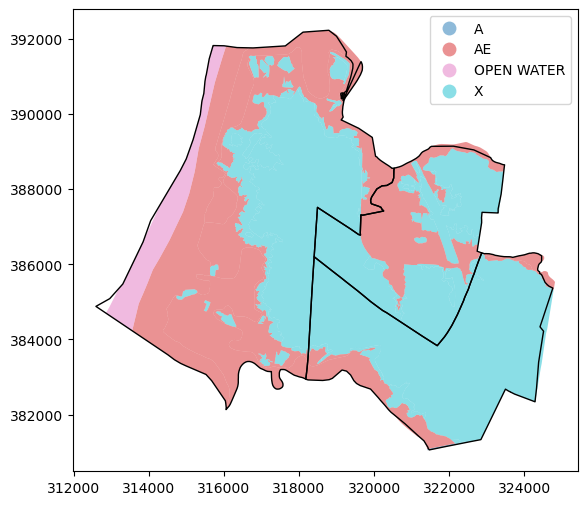

In [97]:
fig, ax = plt.subplots(figsize = (10, 6))
fz.plot(ax=ax, alpha=.5, column='fld_zone', legend=True)
tracts.plot(ax=ax, color='none')

In [121]:
# Turn into wide table for plotting purposes
# Only need to link to tracts geodataframe

# Want summary stats for the tract level
# policies in force, premiums, etc. overall
# and for relevant stratifications (year, flood zone)
# Keep year, but do by flood zone and by tract
# For now, start simple with the most important summary stats
claims_gc_res[claims_gc_res['yearOfLoss'] == 1999].groupby(['tract_id', 'floodZone']).size()

tract_id     floodZone
34007611000  B            1
dtype: int64

In [132]:
# Load in fema assistance/grants
hma_prop_filep = join(fr, 'policy', 'fema_assistance',
                      'HazardMitigationAssistanceMitigatedProperties.csv')
hma_proj_filep = join(fr, 'policy', 'fema_assistance',
                      'HazardMitigationAssistanceProjects.csv')
hma_prop = pd.read_csv(hma_prop_filep,
                       dtype={'stateNumberCode': str,
                              'countyCode': str,
                              'zip': str})
hma_proj = pd.read_csv(hma_proj_filep)

# ihp program
ihp_filep = join(fr, 'policy', 'fema_assistance',
                 'IndividualsAndHouseholdsProgramValidRegistrations.csv')
ihp = pd.read_csv(ihp_filep)

/tmp/ipykernel_1620035/3234367193.py:15: DtypeWarning: Columns (6,8,9,10,11,12,13,20,28,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  ihp = pd.read_csv(ihp_filep)


In [133]:
ihp.columns

Index(['incidentType', 'declarationDate', 'disasterNumber', 'county',
       'damagedStateAbbreviation', 'damagedCity', 'damagedZipCode',
       'applicantAge', 'householdComposition', 'occupantsUnderTwo',
       'occupants2to5', 'occupants6to18', 'occupants19to64',
       'occupants65andOver', 'grossIncome', 'ownRent', 'primaryResidence',
       'residenceType', 'homeOwnersInsurance', 'floodInsurance',
       'registrationMethod', 'ihpReferral', 'ihpEligible', 'ihpAmount',
       'fipAmount', 'haReferral', 'haEligible', 'haAmount', 'haStatus',
       'onaReferral', 'onaEligible', 'onaAmount', 'utilitiesOut', 'homeDamage',
       'autoDamage', 'emergencyNeeds', 'foodNeed', 'shelterNeed',
       'accessFunctionalNeeds', 'sbaEligible', 'sbaApproved', 'inspnIssued',
       'inspnReturned', 'habitabilityRepairsRequired', 'rpfvl', 'ppfvl',
       'renterDamageLevel', 'destroyed', 'waterLevel', 'highWaterLocation',
       'floodDamage', 'floodDamageAmount', 'foundationDamage',
       'founda

In [145]:
ihp[(ihp['county'] == 'Camden (County)') &
    (ihp['damagedStateAbbreviation'] == 'NJ') &
    (ihp['damagedCity'] == 'GLOUCESTER CITY')]['damagedZipCode'].value_counts()

8030    103
Name: damagedZipCode, dtype: int64

In [147]:
ihp[(ihp['damagedZipCode'] == 8030)].groupby(['disasterNumber'])['rpfvl'].sum()

disasterNumber
1530    12267.07
1694    43969.00
4021    37664.90
4086     6626.07
4335        0.00
4488        0.00
Name: rpfvl, dtype: float64

In [131]:
hma_proj[(hma_proj['county'] == 'Camden') &
         (hma_proj['state'] == 'New Jersey')][['subgrantee', 'projectType', 'disasterNumber', 
                                               'benefitCostRatio', 'projectAmount', 
                                               'federalShareObligated',
                                               'costSharePercentage',
                                               'netValueBenefits']]

,subgrantee,projectType,disasterNumber,benefitCostRatio,projectAmount,federalShareObligated,costSharePercentage,netValueBenefits
12794,Somerdale,401.1: Water and Sanitary Sewer System Protect...,4086.0,3.562,130399.00,75000.00,0.58,501245.0
12798,Waterford (Township of),601.2: Generators - Regular,4231.0,2.698,156659.00,117494.00,0.75,520221.0
13065,Camden (County),601.2: Generators - Regular; \n602.1: Other Eq...,4086.0,4.982,964761.02,770074.86,0.80,5285136.0
13072,Camden (County),601.1: Generators,4231.0,1.952,1002000.00,175049.00,0.17,1955463.0
13115,Camden (County),601.2: Generators - Regular,4231.0,2.953,99946.00,74959.00,0.75,325716.0
13307,Winslow (Township of),601.2: Generators - Regular,4086.0,1.770,116561.00,74999.89,0.64,224571.0
20685,Collingswood,200.2: Acquisition of Private Real Property (S...,1295.0,3.825,3066225.00,2299669.00,0.75,12399522.0


## Clean and Filter Parcel data

In [39]:
# Read pc.gpkg
pc_filep = join(fr, 'exposure', 'pc.gpkg')
pc = gpd.read_file(pc_filep)

# Remove "properties" from columns
col_updates = [x.replace("properties.", "") for x in pc.columns]
pc.columns = col_updates

# Subset to relevant columns
keep_cols = ['OBJECTID', 'PAMS_PIN', 'UNIQUEID',
             'HNUM', 'HADD', 'Location',
             'Owner_Street', 'Owner_Csz',
             'Class', 'Bldg_Desc',
             'Land_Value', 'Impr_Value', 'Net_Value',
             'Sale_Date', 'Sale_Price',
             'Facility_Name',
             'Disabled', 'Seniors',
             'Year_Built',
             'geometry']
pc_sub = pc[keep_cols]

# Change cols for float
pc_sub = pc_sub.astype({'Land_Value': float,
                        'Impr_Value': float,
                        'Net_Value': float,
                        'Sale_Price': float,
                        'Year_Built': float})

# Change cols for int
pc_sub['Disabled'] = pc_sub['Disabled'].astype(float).fillna(0).astype(int)
pc_sub['Seniors'] = pc_sub['Seniors'].astype(float).fillna(0).astype(int)

# Check for Location vs. Owner_Street and assign
# owner occupied
pc_sub['owner_occ'] = 0
pc_sub.loc[(pc['Location'] == pc_sub['Owner_Street']) &
           (pc_sub['Owner_Csz'].str.contains('GLOUCESTER CITY')),
           'owner_occ'] = 1

# Sale_Date datetime m/day/year
# Having issues with this, don't need now anyway...
# pc_sub['Sale_Date'] = pd.to_datetime('Sale_Date',
#                                      format="%m%d%Y",
#                                      errors='coerce')

# Write out parcels
pc_out_filep = join(fi, 'exposure', 'pc.gpkg')
pc_sub.to_file(pc_out_filep, driver='GPKG')

## Link Jie's Building Footprints to Parcels

In [148]:
# Read Bld Ftprints with FFE
nsi_filep = join(fi, 'exposure', 'nsi.gpkg')
nsi = gpd.read_file(nsi_filep)

In [134]:
# 
temp = gpd.sjoin(nsi, pc)

In [153]:
temp[temp['Location'] == '216 SOMERSET ST']

,fd_id,bid,occtype,st_damcat,bldgtype,found_type,cbfips,pop2amu65,pop2amo65,pop2pmu65,...,SP_SF,LEADLOT,New_Record,Error,Duplicate,DeedLink,Zoning,Comment,Shape__Area,Shape__Length


In [138]:
temp[temp['Location'] == '218 SOMERSET ST'].iloc[:,0:10]

,fd_id,bid,occtype,st_damcat,bldgtype,found_type,cbfips,pop2amu65,pop2amo65,pop2pmu65
1825,550381727,87F6VVXG+428-3-2-2-3,RES1-1SWB,RES,W,B,340076110005001,2,0,1
1828,550381730,87F6VVXG+428-3-3-3-4,RES1-2SWB,RES,W,B,340076110005001,3,1,1


In [143]:
temp[temp['Location'] == '218 SOMERSET ST'].iloc[:,10:23]

,pop2pmo65,sqft,num_story,ftprntid,ftprntsrc,students,found_ht,val_struct,val_cont,val_vehic,source,med_yr_blt,firmzone
1825,0,1056.0,1,34007_187999,NGA,0,2.0,184901.582,92450.791,27000,P,1939,None
1828,1,2378.0,2,34007_188005,Bing,0,2.0,298712.610,149356.305,27000,P,1939,None


In [154]:
temp[temp['Location'] == '218 SOMERSET ST'].iloc[:,100:110]

,VCS,Zone,Lot_Size,Style,UpdCd,Year_Built,Sf_Area,Type_Use,Basement,Finbsmt
1825,None,None,000001185,None,20,1900,None,08030,None,None
1828,None,None,000001185,None,20,1900,None,08030,None,None


In [170]:
pc[pc['Location'] == '216 SOMERSET ST'].iloc[:,30:40]

,Exmpt1_Value,Impr_Value,Net_Value,Partial_Asmt,Sale_Date,Sale_Book,Sale_Page,Sale_Price,Sale_Nu,Bank_Cd
4103,00000000,000046200,000063700,None,032619,11112,01604,000014000,26,None


In [169]:
pc[pc['Location'] == '218 SOMERSET ST'].iloc[:,30:40]

,Exmpt1_Value,Impr_Value,Net_Value,Partial_Asmt,Sale_Date,Sale_Book,Sale_Page,Sale_Price,Sale_Nu,Bank_Cd
2768,00000000,000086800,000115600,None,033006,08176,00741,000147000,None,None


## Link depths to structures

In [34]:
# Link Depth Grids
# Link BFEs
# Link Sara's Flood Event
# To both the NSI & the "custom" structure inventory

['peak_fld_depth_0.0375.tif',
 'peak_fld_depth_0.0125.tif',
 'peak_fld_depth_0.035.tif',
 'peak_fld_depth_0.05.tif',
 'peak_fld_depth_0.02.tif',
 'peak_fld_depth_0.0275.tif',
 'peak_fld_depth_0.025.tif',
 'peak_fld_depth_0.0225.tif',
 'peak_fld_depth_0.0175.tif',
 'peak_fld_depth_0.0325.tif',
 'peak_fld_depth_0.03.tif',
 'peak_fld_depth_0.04.tif',
 'peak_fld_depth_0.1.tif',
 'peak_fld_depth_0.07.tif',
 'peak_fld_depth_0.045.tif',
 'peak_fld_depth_0.09.tif',
 'peak_fld_depth_0.08.tif',
 'peak_fld_depth_0.01.tif',
 'peak_fld_depth_0.06.tif',
 'peak_fld_depth_0.015.tif']

In [35]:
# Read in NSI data
INT_EXP_FILEP = join(fi, 'exposure')
nsi_gdf = gpd.read_file(join(INT_EXP_FILEP, 'nsi.gpkg'))

# Get coordinate list
coord_list = [(x, y) for x, y in
              zip(nsi_gdf['geometry'].x,
                  nsi_gdf['geometry'].y)]

# List of depth series
depth_list = []

# For each depth raster, link up unique property
# coordinates with the corresponding depth values
# Write out file of coord/id index & depth_suf columns
depth_filenames = os.listdir(HAZ_OUT_DIR)

for d_fn in depth_filenames:
    # Filepath and load
    d_grid_fp = join(HAZ_OUT_DIR, d_fn)
    # Open the depth raster in read mode
    d_grid = rasterio.open(d_grid_fp)

    # Get the suffix
    # First, get the pre .tif str component
    filepre = d_fn.split('.tif')[0]
    # Then get last element splitting on "_"
    d_suf = filepre.split('_')[-1]

    # Sample points from the raster based on nsi coordinates
    # Get sampled values from pixels
    sampled_depths = [x[0] for x in d_grid.sample(coord_list)]

    # Store as series with name
    # Index by fd_id
    # depth_d_suf
    depth_series = pd.Series(sampled_depths,
                             index=nsi_gdf['fd_id'],
                             name='depth_' + d_suf)

    # Convert depth to ft
    depth_series = depth_series * 3.281

    # Store in list
    depth_list.append(depth_series)
    
# Concat into dataframe
depths = pd.concat(depth_list, axis=1)

# Write data frame to file
# Exposure/depths links depths to properties
EXP_OUT_DIR = join(fp, 'exposure')
Path(EXP_OUT_DIR).mkdir(parents=True, exist_ok=True)
DEPTHS_OUT_FILEP = join(EXP_OUT_DIR, 'depths.pqt')
# fd_id is index, so set index=True
depths.to_parquet(DEPTHS_OUT_FILEP,
                  index=True)

In [ ]:
# Write out id/depthBFE,depth1Coast,depth2019 file
# both NSI and Jie bld fp

## Subset to residential structures and write out

In [38]:
# Subset pc & nsi to res structures
# Get NSI bld_fp and Jie bld_fp centroid in ref (bg, tract, zip)
# Then write out

# Get residential structures
nsi_res = nsi_gdf.loc[nsi_gdf['st_damcat'] == 'RES']

# TODO: Need to update occtype variable to OPEN or ENC
# when pile or pier found_type exists, but not
# relevant for this first case study so avoiding the code

# Write out to processed/exposure/
EXP_OUT_FILEP = join(EXP_OUT_DIR, 'nsi_res.gpkg')
nsi_res.to_file(EXP_OUT_FILEP, driver='GPKG')

# Process depth damage functions

In [41]:
# Filepath to NACCS depth damage functions
vul_dir = join(fr, 'vulnerability', 'physical')
# Read ddfs
naccs = pd.read_csv(join(vul_dir, 'naccs_ddfs.csv'))

In [42]:
# Need to write file in tidy format

# Drop Description and Source columns
# Melt on occupancy damage category
# Each depth is associated with a percent damage
dropcols = ['Description', 'Source']
idvars = ['Occupancy', 'DamageCategory']
naccs_melt = naccs.drop(columns=dropcols).melt(id_vars=idvars,
                                               var_name='depth_str',
                                               value_name='pctdam')

# Need to convert depth_ft into a number
# Replace ft with empty character
# If string ends with m, make negative number
# Else, make positive number
naccs_melt['depth_str'] = naccs_melt['depth_str'].str.replace('ft', '')
negdepth = naccs_melt.loc[naccs_melt['depth_str'].str[-1] == 
                          'm']['depth_str'].str[:-1].astype(float)*-1
posdepth = naccs_melt.loc[naccs_melt['depth_str'].str[-1] != 
                          'm']['depth_str'].astype(float)

naccs_melt.loc[naccs_melt['depth_str'].str[-1] == 'm',
               'depth_ft'] = negdepth
naccs_melt.loc[naccs_melt['depth_str'].str[-1] != 'm',
               'depth_ft'] = posdepth

# Divide pctdam by 100
naccs_melt['reldam'] = naccs_melt['pctdam']/100

# Delete depth_str and pctdam and standardize
# column names
dropcols = ['depth_str', 'pctdam']
newcols = ['occtype', 'damcat', 'depth_ft', 'reldam']
naccs_melt = naccs_melt.drop(columns=dropcols)
naccs_melt.columns = newcols

# Write out to processed/vulnerability/
vuln_out_dir = join(fp, 'vulnerability', 'physical')
Path(vuln_out_dir).mkdir(parents=True, exist_ok=True)
vuln_out_filep = join(vuln_out_dir, 'naccs_ddfs.csv')
naccs_melt.to_csv(vuln_out_filep, index=False)